## Задание

### Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Данные   
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:
    
- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 лайки/просмотры ∗1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:
    
- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

Файлы:

- users_test – информация о пользователях в тестовой группе. 
- users_control_1 – информация о пользователях в первой контрольной группе. 
- users_control_2 – информация о пользователях во второй контрольной группе . 
- transactions_test – информация о платежах пользователей в тестовой группе. 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

### ПЛАН РАБОТЫ:
1) Определение метрик для проверки успешности эксперимента

2) Загрузка данных, проверка данных в датасете, предобработка данных

3) Проверка выборок на репрезентативность

4) А/А тестирование. Проверка системы сплитования

5) А/В тестирование

6) Вывод: был ли эксперимент успешен.

### 1) Определение метрик для проверки успешности эксперимента

Метрики:
- средняя выручка всех пользователей сайта - ARPU, средняя выручка обладателей премиум подписки - ARPPU.
- конверсия пользователя в премиум пользователя -CR


### 2) Загрузка данных, проверка данных в датасете, предобработка данных

In [1]:
import pandas as pd
import datetime as dt
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import numpy as np  
import pingouin as pg
import scipy.stats 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import tqdm

In [2]:
#Загрузка данных:
users_test = pd.read_csv('Проект_3_users_test.csv', encoding='windows-1251', sep=(';'))
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', encoding='windows-1251', sep=(';'))
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', encoding='windows-1251', sep=(';'))

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
transactions_test = pd.read_csv('Проект_3_transactions_test.csv', parse_dates=['joined_at', 'paid_at'], encoding='windows-1251', sep=(';'))
transactions_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', parse_dates=['joined_at', 'paid_at'], encoding='windows-1251', sep=(';'))
transactions_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', parse_dates=['joined_at', 'paid_at'], encoding='windows-1251', sep=(';'))

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
users_test.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0


In [5]:
users_control_1.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0


In [6]:
users_control_2.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0


`Столбцы в таблице users однотипны. Я объединяю все три таблицы users, 
чтобы проверить число наблюдений и столбцов, типы данных, наличие пропущенных значений. 
А также, с объединенной таблицей удобней проводить дальнейшие мероприятия в рамках нашего анализа.
Для обозначения первоначальных групп, я создаю колонку groups.

In [7]:
users_test['groups'] = 'test'
users_control_1['groups'] = 'control_1'
users_control_2['groups'] = 'control_2'

In [8]:
users = pd.concat([users_test, users_control_1, users_control_2])
users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test


`Все таблицы включены в итоговую, т.к. совпадает количество строк в группе с количеством в первоначальной таблице:

In [9]:
print(f'число строк в датасетах users:  ',users_test.shape[0]+users_control_1.shape[0]+users_control_2.shape[0])

число строк в датасетах users:   12912


In [10]:
print(f'число строк в объединенном users:  ', users.shape[0])

число строк в объединенном users:   12912


In [11]:
users.groups.value_counts()

control_1    4340
test         4308
control_2    4264
Name: groups, dtype: int64

`Аналогичные действия и для transactions.
Я объединяю все три таблицы transactions. 
Для обозначения первоначальных групп, я создаю колонку groups. Проверяю количество строк.

In [12]:
transactions_test['groups'] = 'test'
transactions_control_1['groups'] = 'control_1'
transactions_control_2['groups'] = 'control_2'

In [13]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test


In [14]:
print(f'число строк в датасетах users:  ',transactions_test.shape[0]+transactions_control_1.shape[0]+transactions_control_2.shape[0])

число строк в датасетах users:   1608


In [15]:
print(f'число строк в объединенном users:  ', transactions.shape[0])

число строк в объединенном users:   1608


In [16]:
transactions.dtypes

uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
groups                  object
dtype: object

In [17]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [18]:
transactions.uid.value_counts()

892333905.0    27
892236423.0    14
892069554.0    11
891637005.0    11
891367521.0    10
               ..
891952095.0     1
892052106.0     1
892003728.0     1
892032072.0     1
891291531.0     1
Name: uid, Length: 526, dtype: int64

`В таблице transactions одному пользователю может принадлежать несколько транзакций.

In [19]:
transactions.nunique()

uid             526
country          23
joined_at       525
paid_at         893
revenue         265
payment_id        7
from_page        28
product_type      4
groups            3
dtype: int64

In [20]:
transactions.sort_values('joined_at').head(20)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1
196,891561825.0,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636.0,147.0,trial_vip_popup,trial_premium,control_1
342,891561825.0,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins,control_1
368,891561825.0,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins,control_1
43,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:08:00,897.0,146.0,menu,coins,test
6,891558921.0,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,test
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial,control_1
18,891555327.0,Argentina,2017-01-11 06:46:00,2017-08-11 08:46:00,13767.0,147.0,trial_vip_popup,trial_premium,test


`Транзакции начинаются в 2015 году. Однако в 2015 году только 3 транзакции. Основная часть пользователей присоединилась начиная с 2017-01-11.

In [21]:
transactions[transactions['joined_at'] == "2015-01-19 11:49:00"]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


`Как видно из выборки, в 2015 году был всего 1 пользователь с 3 транзакциями. Поскольку он был давно и всего 1, то его можно не засчитывать в целях однородности групп по времени.

In [22]:
transactions = transactions[transactions['joined_at'] != "2015-01-19 11:49:00"]

In [23]:
transactions.describe(include='datetime64')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,joined_at,paid_at
count,975,975
unique,524,890
top,2017-10-16 01:38:00,2017-10-16 02:08:00
freq,27,5
first,2017-01-11 01:06:00,2017-01-11 02:56:00
last,2017-10-31 23:40:00,2017-12-11 23:28:00


#### Предобработка таблицы users. 

In [24]:
# Проверяю типы данных, они меня устраивают.  
users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
groups               object
dtype: object

In [25]:
users.isna().sum() # Наличие пропущенных значений. Пропусков в столбце uid с индетификаторами пользователей - нет.

uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
groups                  0
dtype: int64

In [26]:
users.shape

(12912, 14)

In [27]:
users.uid.nunique() # Повторений нет 

12912

`По условиям задачи изменения цены подписки произошли в некоторых странах. 
Выясню в каких странах изменение цены не проводилось и удалю из моего исследования

In [28]:
country_users = users.groupby(['country', 'groups'], as_index=False) \
                         .agg({'uid':'count'}) \
                         .rename(columns = {'uid': 'count'}) \
                         .sort_values(['country', 'groups'], ascending=True)
country_users

,country,groups,count
0,Algeria,control_1,2
1,Algeria,test,2
2,Argentina,control_1,389
3,Argentina,control_2,397
4,Argentina,test,396
...,...,...,...
131,United States of America,test,1450
132,Uruguay,control_2,1
133,Uruguay,test,1
134,Uzbekistan,test,1


In [29]:
country_users_1 = country_users.pivot_table(index = 'country', columns='groups', values='count', fill_value=0) \
                               .sort_values('test', ascending=False).reset_index()
country_users_1.head()  

groups,country,control_1,control_2,test
0,United States of America,1471,1486,1450
1,Argentina,389,397,396
2,France,370,376,359
3,Italy,338,293,323
4,Spain,342,310,301


In [30]:
country_users_1.query('test == 0') #есть страны, в которых тестовое изменение цены на подписку не проводилось. 

groups,country,control_1,control_2,test
51,Sweden,1,0,0
52,Somalia,0,1,0
53,Uganda,0,1,0
54,Lithuania,0,1,0
55,Qatar,1,1,0
56,Jamaica,1,0,0
57,Armenia,1,0,0
58,Austria,0,2,0
59,Belarus,0,1,0
60,Burkina Faso,1,0,0


`Т.е. в колонке test ноль стран. Для АА-тестирования группы должны быть более однородные.
Это означает, что нас интересуют только те страны, гре проводилось тестовое изменение.
Я удаляю страны, где тестовое изменение НЕ проводилось.

In [31]:
country_for_drop = list(country_users_1.query('test == 0').country)
country_for_drop

['Sweden',
 'Somalia',
 'Uganda',
 'Lithuania',
 'Qatar',
 'Jamaica',
 'Armenia',
 'Austria',
 'Belarus',
 'Burkina Faso',
 'China',
 'Czech Republic',
 'Kuwait',
 'Paraguay',
 'Malaysia',
 'Mali',
 'Moldova, Republic of',
 'New Zealand',
 'Nicaragua',
 'Panama',
 'Venezuela']

In [32]:
users = users[~users['country'].isin(country_for_drop)]
users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test


In [33]:
users.shape

(12887, 14)

In [34]:
users.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

`В целях моего исследования необходимо выяснить был ли хоть раз у пользователя премиум. 
В таблице Users две колонки содержат информацию о подписке:
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум   

Насколько эти две колонки дублируют друг друга?

In [35]:
users.query('was_premium != 1 and is_premium == 1.0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups


In [36]:
users.query('was_premium == 1 and is_premium != 1.0').shape

(715, 14)

In [37]:
users.query('was_premium == 1 and is_premium == 1.0').shape

(538, 14)

In [38]:
users.query('is_premium == 1.0').shape 

(538, 14)

In [39]:
users['was_premium'] = users['was_premium'].fillna(0) # заполню отсутствующие значения 
users['is_premium'] = users['is_premium'].fillna(0)

In [40]:
users.sort_values('was_premium', ascending=False)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups
1861,891296772,32,500,NaN,France,"1,3,4,5,6",1,29,35,6,1.0,1.0,0,test
3797,891218568,59,777,NaN,United States of America,NaN,1,56,62,27,1.0,1.0,0,control_1
2602,892280826,21,291,NaN,United States of America,1,1,16,47,24,1.0,0.0,0,control_2
2606,892247952,26,359,NaN,United States of America,"1,2,3,7,10,11,12,16,17,18",1,23,29,103,1.0,1.0,6422,control_2
1829,892295766,19,500,NaN,United States of America,"1,2",1,16,22,6,1.0,0.0,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,891690714,23,142,NaN,United States of America,"1,2,3,4,5,6,7,8",1,20,26,7,0.0,0.0,0,control_1
200,891179868,36,111,NaN,Germany,1,1,33,39,9,0.0,0.0,0,control_1
201,892359597,26,333,NaN,Switzerland,"1,2,3",1,23,29,3,0.0,0.0,0,control_1
202,891692985,32,454,NaN,United States of America,"1,3,4,5,7,9,11,12,13,14,15",1,29,35,11,0.0,0.0,0,control_1


`Получается, что если пользователь является премиумом на данный момент (is_premium), то это означает, 
что у него в колонке was_premium будет единица. Для дальнейшего исследования является важным, 
был ли премиум хоть раз. Значит для анализа лучше использовать колонку 'was_premium", 
которая включает в себя и информацию о том, является ли сейчас пользователь премиум.

`Поподробнее разберу колонку 'coins':

In [41]:
users.query('coins > 0 & total_revenue < 1')[['coins', 'was_premium', 'is_premium', 'total_revenue']]

,coins,was_premium,is_premium,total_revenue
2080,2.0,1.0,0.0,0
2937,8466.0,1.0,1.0,0
378,26.0,1.0,0.0,0
1695,3.0,0.0,0.0,0
2326,20.0,0.0,0.0,0


`5 пользователей имеют монеты, но при этом их total_revenue = 0.  
Даются ли монеты бесплатно? Вполне возможно. Это зависит от бизнес-модели, от доп.услуг приложения. 
Вполне возможно, что монеты можно "заработать" выполняя определенные условия дейтинговой платформы 
(как то: 100% заполнение анкеты, привязка личного кошелька, подтверждение личности) либо задания в игровой форме, 
которые стимулируют пользователя дольше висеть онлайн.  
Кроме того, наверняка монеты можно потратить на приобретение Премиум. 
Тогда total_revenue тоже будет нулевой, ведь потрачены не реальные деньги

Таким образом, относительно монет я не вижу противоречия в данных.

In [42]:
#посмотрим сколько людей имело подписку и при этом total_revenue 0
users.query('was_premium == 1 & total_revenue < 1')[['was_premium', 'total_revenue']]

,was_premium,total_revenue
4,1.0,0
13,1.0,0
36,1.0,0
58,1.0,0
59,1.0,0
...,...,...
4186,1.0,0
4191,1.0,0
4204,1.0,0
4211,1.0,0


`Достаточно много пользователей, неоплативших свой Премиум.  

Моё первое предположение было таким, что на некоторых сайтах для знакомства, 
имеется услуга подарка Премиум статуса от пользователя пользователю. 
Тогда можно предположить, что данным 761 пользователю Премиум был подарен в рамках знакомства. 

Второе предположение состоит в том, что возможно у многих людей с подпиской Премиум 
и нулевым total_revenue есть НЕнулевое revenue из таблицы transactions
Для проверки присоединю обе таблицы по uid.

In [43]:
# всего один человек, у которого есть премиум, нулевой total_revenue и большая сумма в revenue:
users.merge(transactions, how='left', on='uid') \
    .query('was_premium == 1 & total_revenue < 1 & revenue > 1')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,groups_x,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups_y
7957,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,...,0,control_1,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,control_1


In [44]:
#посмотрим еще есть ли пользователи у которых total_revenue есть, а revenue нет
users.merge(transactions, how='left', on='uid') \
    .query('total_revenue > 1 & revenue < 1').shape[0]

0

`Можно предположить, что у пользователей Премиум и 0 total_revenue, потому что у них пробная подписка, и она бесплатная. 
В описании данных сказано: "При этом стоимость пробного периода оставалась прежней". Значит пробная подписка платная. 
Можно проверить, чтоб быть точно уверенным
Сделаю pivot по 'product type' из таблицы transactions.

In [45]:
# Получается, что существуют пользователи, у которых везде 0, кроме trial_premium.
pd.pivot_table(transactions[transactions.uid.notna()]
               [['uid', 'revenue', 'product_type']], index='uid', columns='product_type', fill_value=0)

revenue                                          
product_type   coins other_type premium_no_trial trial_premium
uid                                                           
891068079.0   4004.0        0.0           6292.0             0
891071157.0      0.0        0.0           9100.0             0
891075072.0      0.0     2327.0              0.0             0
891077727.0      0.0        0.0           6292.0             0
891080040.0   1261.0     3783.0              0.0             0
...              ...        ...              ...           ...
892431081.0      0.0        0.0              0.0          9087
892434141.0   5551.0        0.0           3614.0             0
892435536.0    897.0     2730.0           4537.0             0
892438635.0      0.0        0.0              0.0         16653
892438776.0      0.0        0.0              0.0         12727

[525 rows x 4 columns]

`Далее посмотрю на 1 пользователя, чтоб не было путаницы. Вышло, 
что у него только одно действие, пробная подписка, Премиум он не оформлял. 
При этом у него есть сумма, которую он заплатил в колонке trial_premium

In [46]:
pd.pivot_table(transactions[transactions.uid.notna()]
               [['uid', 'revenue', 'product_type']], index='uid', columns='product_type', fill_value=0) \
    .query('uid == "892438635"')

revenue                                          
product_type   coins other_type premium_no_trial trial_premium
uid                                                           
892438635.0      0.0        0.0              0.0         16653

In [47]:
transactions.query('uid == "892438635"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
159,892438635.0,France,2017-10-14 00:58:00,2017-10-23 12:55:00,16653.0,147.0,trial_vip_popup,trial_premium,test


Ниже этот же пользователь из таблицы users. Здесь он was_premium, при этом покупал только пробную подписку

In [48]:
users.query("uid == '892438635'")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups
3389,892438635,25,500,NaN,France,"1,2,3,4,5,6,8,9,10,12,13,14,16,17",1,22,28,16,1.0,1.0,16653,test


Значит поле 'was_premium' содержит информацию не только о Премиум, но и о пробной подписке trial_premium. 
В цлом 'was_premium' не оправдал моих ожиданий относительно точности информации о Премиуме, т.к. содержит много лишней информации и о других продуктах.
Поэтому для определения Премиум пользователей я буду использовать колонку с типом продукта из таблиции транзакций.


`Я хочу разделить пользователей на типы в зависимости от подписки. Информацию о подписке буду добавлять из transactions

In [49]:
transactions

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test
...,...,...,...,...,...,...,...,...,...
323,891985866.0,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147.0,trial_vip_popup,trial_premium,control_2
324,891491145.0,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727.0,147.0,send_message,trial_premium,control_2
325,892053750.0,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261.0,19.0,autorefill,coins,control_2
326,891668253.0,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997.0,147.0,trial_vip_popup,trial_premium,control_2


In [50]:
transactions.value_counts('product_type')

product_type
coins               379
premium_no_trial    289
trial_premium       182
other_type          125
dtype: int64

In [51]:
# Как видно одному пользователь мог приобретать несколько различных продуктов. 
transactions.groupby(['uid', 'product_type'], as_index=False) \
    .agg({'groups': 'count'}).sort_values(['uid','groups'], ascending = False).head()

,uid,product_type,groups
715,892438776.0,trial_premium,1
714,892438635.0,trial_premium,1
711,892435536.0,coins,2
713,892435536.0,premium_no_trial,2
712,892435536.0,other_type,1


`Я добавлю в users столбец с информацией о приобретенном продукте. В первую очередь меня интересует приобретал ли пользователь Премиум, затем пробную подписку, затем всё остальное. Поэтому подготовлю транзакции по приоритету и добавлю в users

In [52]:
# Сортируем transactions по приоритету значений 'premium_no_trial', 'trial_premium' и 'other'
transactions['priority'] = pd.Categorical(transactions['product_type'], categories=['premium_no_trial', 'trial_premium', 'coins', 'other_type'], ordered=True)
transactions_sorted = transactions.sort_values(['uid', 'priority'])
transactions_sorted.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups,priority
298,891068079.0,Argentina,2017-10-11 11:45:00,2017-12-11 15:23:00,6292.0,147.0,promo_09,premium_no_trial,control_2,premium_no_trial
48,891068079.0,Argentina,2017-10-11 11:45:00,2017-11-11 04:20:00,4004.0,146.0,empty_likes,coins,control_2,coins
22,891071157.0,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100.0,147.0,promo_09,premium_no_trial,test,premium_no_trial


In [53]:
# Группируем таблицу transactions по uid и берем первое значение с наивысшим приоритетом
grouped_transactions = transactions_sorted.groupby('uid').first().reset_index()
grouped_transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups,priority
0,891068079.0,Argentina,2017-10-11 11:45:00,2017-12-11 15:23:00,6292.0,147.0,promo_09,premium_no_trial,control_2,premium_no_trial
1,891071157.0,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100.0,147.0,promo_09,premium_no_trial,test,premium_no_trial
2,891075072.0,United States of America,2017-10-11 08:23:00,2017-11-14 21:44:00,2327.0,67.0,empty_likes,other_type,control_2,other_type


In [54]:
# Присоединяем отранжированные значения к таблице users по ключу 'uid'
users_and_types = pd.merge(users, grouped_transactions[['uid', 'product_type']], on='uid', how='left')
users_and_types.product_type.fillna('no payment', inplace=True)  # Заменяем пропущенные значения на 'no payment'
users_and_types.value_counts('product_type')

product_type
no payment          12364
premium_no_trial      267
trial_premium         179
coins                  61
other_type             16
dtype: int64

In [55]:
# Сверяю сколько данных я "потеряла" за счет merge. Немного.
transactions.value_counts('product_type')

product_type
coins               379
premium_no_trial    289
trial_premium       182
other_type          125
dtype: int64

In [56]:
users_and_types.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

In [57]:
users_and_types.sort_values('product_type')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type
530,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,0.0,0.0,741,test,coins
8166,892102893,31,550,40.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11",1,28,34,138,0.0,0.0,25220,control_1,coins
7264,892069554,47,185,8.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,38,1414,0.0,0.0,59267,control_1,coins
11044,891308457,18,357,38.0,Belgium,1,1,15,21,112,1.0,0.0,6227,control_2,coins
4782,891989511,25,166,110.0,United States of America,"1,2,3",1,16,54,6,1.0,0.0,12389,control_1,coins
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279,891904293,34,766,NaN,United States of America,NaN,1,31,37,30,1.0,1.0,12727,test,trial_premium
9901,892128138,32,301,42.0,Argentina,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,21,35,196,1.0,1.0,30849,control_2,trial_premium
2631,891806280,19,0,NaN,United States of America,1,1,16,22,10,1.0,1.0,8242,test,trial_premium
10965,891655107,36,271,10.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,33,39,302,1.0,1.0,17264,control_2,trial_premium


In [58]:
users_and_types.query('total_revenue !=0 and product_type == "no payment"') 
# значит я права и no payment это пользователи не принесшие приложению ни одного total_revenue 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type
4817,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control_1,no payment


Я считаю, что на платформе присутствуют 3 типа пользователей:

- Те, кто приобретал платную подписку Премиум - 'premium user'
- Те, кто только приобретал пробную версию - 'pilot user'
- Те, кто не приобретал подписку Премиум и пробную версию - 'simple user'

Создадим колонку с информацией о типе пользователя.

In [59]:
users_and_types['user_type'] = users_and_types.apply(lambda x: 'premium user' if x['product_type'] == "premium_no_trial"                                                     
                                                      else 'pilot user' if x['product_type'] == "trial_premium" 
                                                      else 'simple user', axis=1)
users_and_types.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,0.0,0.0,0,test,no payment,simple user
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,no payment,simple user
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,0.0,0,test,no payment,simple user


In [60]:
users_and_types.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

`Получим колонку с числом дней, которые провел пользователь на платформе. 
Для этого преобразуем колонку visit_days. Но сначала проверим NaN.

In [61]:
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,0.0,0.0,0,test,no payment,simple user
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user


In [62]:
users_and_types.query('visit_days.isna()').shape[0]

4016

`Значений с NaN достаточно много, поэтому нецелесообразным будет их удаление.

`Я сделаю следующим образом: сначала найду медианные значения числа дней для каждого из типов пользователей (user_type).
Укажу для пользователей с NaN значения числа дней посещения равными медианным значениям для конкретной категории.
То есть если пользователь с платной версией и число дней не определено, то поставим ему медианное значение числа дней для категории "premium user"

In [63]:
# Создаю новую колонку 'temperary_days' с информацией о числе дней без учета NaN:
users_and_types['visit_days'] = users_and_types['visit_days'].fillna('').astype(str)
users_and_types['temperary_days'] = users_and_types['visit_days'].apply(lambda x: len(x.split(',')))

In [64]:
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20


`Проверяю дубликаты юзеров:

In [65]:
users_and_types.groupby('uid').agg({'groups': 'count'}).max()

groups    1
dtype: int64

In [66]:
users_and_types.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

`Значит, что нет повторов пользователей в выборках, поэтому не требуется проводить удаление дубликатов

В дальнейшем мне понадобится информация о доходах , поступающая от пользователей Премиум. 
Колонки revenue и total_revenue мне не подходит, т.к. первая содержит только информацию о доходе по транзакции, а вторая  - включает в себя общую сумму доходов пользователя по всем продуктам. 
Поэтому добавю в таблицу сумму доходов по продуктам, в том числе от Премиум подписки по пользователю.

In [67]:
transactions

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups,priority
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test,trial_premium
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test,trial_premium
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test,other_type
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test,other_type
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test,trial_premium
...,...,...,...,...,...,...,...,...,...,...
323,891985866.0,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147.0,trial_vip_popup,trial_premium,control_2,trial_premium
324,891491145.0,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727.0,147.0,send_message,trial_premium,control_2,trial_premium
325,892053750.0,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261.0,19.0,autorefill,coins,control_2,coins
326,891668253.0,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997.0,147.0,trial_vip_popup,trial_premium,control_2,trial_premium


In [68]:
# создаю новый revenue_product,  в котором посчитаю по транзакциям траты пользователя на продукт, доход приложения в разрезе продуктов.

revenue_product = transactions.groupby(['uid','product_type'], as_index=False).agg({'revenue': 'sum'})\
        .rename(columns={'revenue' : 'revenue_from_product'})
revenue_product.sort_values('revenue_from_product')

,uid,product_type,revenue_from_product
108,891317289.0,coins,481.0
591,892205850.0,coins,533.0
339,891777708.0,other_type,624.0
269,891653790.0,coins,728.0
112,891319275.0,coins,728.0
...,...,...,...
616,892236423.0,coins,66833.0
340,891778551.0,premium_no_trial,81796.0
33,891178380.0,premium_no_trial,113477.0
470,892038759.0,premium_no_trial,113477.0


In [69]:
users_and_types.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

In [70]:
# Добавлю данные по доходам о продуктам по двум ключам
users_and_types = pd.merge(users_and_types, revenue_product, on=['uid', 'product_type'], how='left')
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,NaN
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,NaN


In [71]:
# проверяю не потеряла ли я пользователей в тестовой и контрольных группах. Не потеряла.
users_and_types.groups.value_counts()

control_1    4330
test         4308
control_2    4249
Name: groups, dtype: int64

In [72]:
# Сравниваю итоговые суммы по столбцам revenue_from_product и total_revenue:
users_and_types.total_revenue.sum()

6777589

In [73]:
users_and_types.revenue_from_product.sum()

5066282.0

In [74]:
# Есть отсутсвующие значения в 'revenue_from_product'. 
users_and_types['revenue_from_product'].isnull().value_counts()

True     12364
False      523
Name: revenue_from_product, dtype: int64

In [75]:
# Для принятия решения что с ними делать, сравню с 'total_revenue' этих же пользователей
users_and_types.query('total_revenue == 0 and revenue_from_product.isnull()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,NaN
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,NaN
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,NaN
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,no payment,simple user,12,NaN
4,891406035,27,1000,NaN,France,,1,24,30,1,1.0,0.0,0,test,no payment,simple user,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12882,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,0.0,0.0,0,control_2,no payment,simple user,2,NaN
12883,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,control_2,no payment,simple user,13,NaN
12884,891096429,41,333,NaN,United States of America,,1,38,44,6,0.0,0.0,0,control_2,no payment,simple user,1,NaN
12885,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,control_2,no payment,simple user,9,NaN


In [76]:
users_and_types.query('total_revenue == 0 and revenue_from_product.notnull()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
7670,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0,control_1,other_type,simple user,29,30264.0


In [77]:
# 1 пользователь имеет total_revenue != 0
users_and_types.query('total_revenue != 0 and revenue_from_product.isnull()')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
4817,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control_1,no payment,simple user,27,NaN


In [78]:
# Этого пользователя не было в transactions...
transactions.query('uid == "960936960"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,groups,priority


In [79]:
# ... но этот пользователь был в таблице users.
users.query('uid == "960936960"')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control_1


Поскольку отсутсвуют фин. транзакции по данному пользователю "960936960",
принимаю решение оставить его с доходом revenue_from_product ==0

In [80]:
users_and_types['revenue_from_product'] = users_and_types['revenue_from_product'].fillna(0)
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,0.0
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,0.0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,0.0


**После окончания предобработки данных число данных уменьшилось незначительно. 
Сформирован датасет, в котором три группы пользователей (тестовая и две контрольных) (регистрация в период эксперимента с 11.01.2017 по 31.10.2017) из нескольких стран (страны в контрольных группах совпадают с тестовой).
Каждому пользователю добавлена сумма его трат в первую очередь на подписку Премиум, на пробную подписку и на остальные продукты.
Таким образом, датасет, с которым в дальнейшем буду проводить анализ предобработанных данных users готов.**

### 3) Проверка выборок на репрезентативность

In [81]:
df = users_and_types.groupby(['user_type'], as_index=False) \
    .agg({'revenue_from_product': 'sum'}) \
    .rename(columns={'revenue_from_product': 'revenue_sum'}).sort_values('revenue_sum', ascending = False)
df

,user_type,revenue_sum
1,premium user,2330718.0
0,pilot user,2191683.0
2,simple user,543881.0


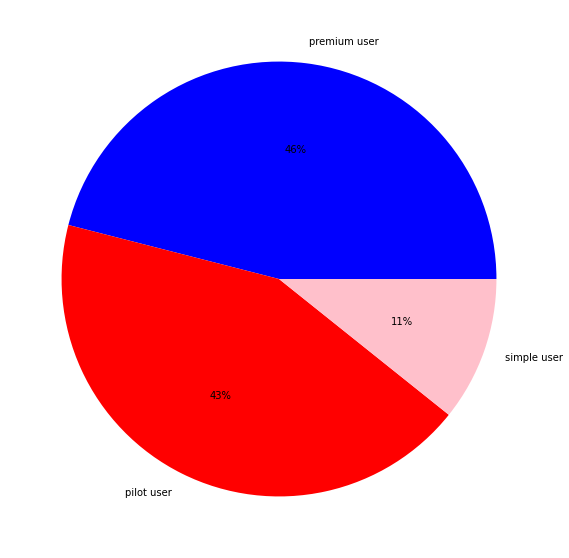

In [82]:
plt.figure(figsize=(10, 10))
plt.pie(df['revenue_sum'], labels=df['user_type'], autopct='%.0f%%', 
        colors=['blue', 'red', 'pink', 'yellow'])
plt.show()
# Как видно по диагамме, траты пользователей на Премиум и Пробную подписку примерно одинаковые 

In [83]:
users_and_types.nunique()

uid                     12887
age                        68
attraction_coeff          847
coins                      50
country                    51
visit_days               2129
gender                      2
age_filter_start           67
age_filter_end             81
views_count               562
was_premium                 2
is_premium                  2
total_revenue             292
groups                      3
product_type                5
user_type                   3
temperary_days             31
revenue_from_product      230
dtype: int64

In [84]:
users_and_types.describe(include='object')

,country,visit_days,groups,product_type,user_type
count,12887,12887,12887,12887,12887
unique,51,2129,3,5,3
top,United States of America,,control_1,no payment,simple user
freq,4407,4016,4330,12364,12441


In [85]:
users_and_types.describe(include=['float', 'int'])

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,temperary_days,revenue_from_product
count,1.288700e+04,12887.000000,12887.000000,169.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000,12887.000000
mean,8.917568e+08,32.003957,315.288275,692.970414,0.955149,26.816482,38.553969,46.322185,0.097230,0.041747,525.924498,4.865523,393.131218
std,1.611763e+06,10.214975,323.482240,7713.620395,0.206986,9.448246,15.491764,283.877900,0.296282,0.200019,5527.972118,6.008220,2830.111051
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8.913563e+08,25.000000,0.000000,6.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,8.917253e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,8.920860e+08,38.000000,529.000000,28.000000,1.000000,32.000000,45.000000,21.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.000000,1.000000,486330.000000,31.000000,113477.000000


`Посмотрим на гендер. В таблице есть колонка гендер со значениями 0 и 1, следовательно это гендеры мужчина и женщина.
Но в задании явно не указано где какой гендер. Оставлю обозначения гендеров так, как представлено в таблице, проведу анализ. А кто скрывается за этими обозначениями я бы дополнительно уточнила в источнике данных. 
Также, по диаграмме мы видим, что процентное соотношение гендера 1 на сайте знакомств значительно выше числа гендера 0.

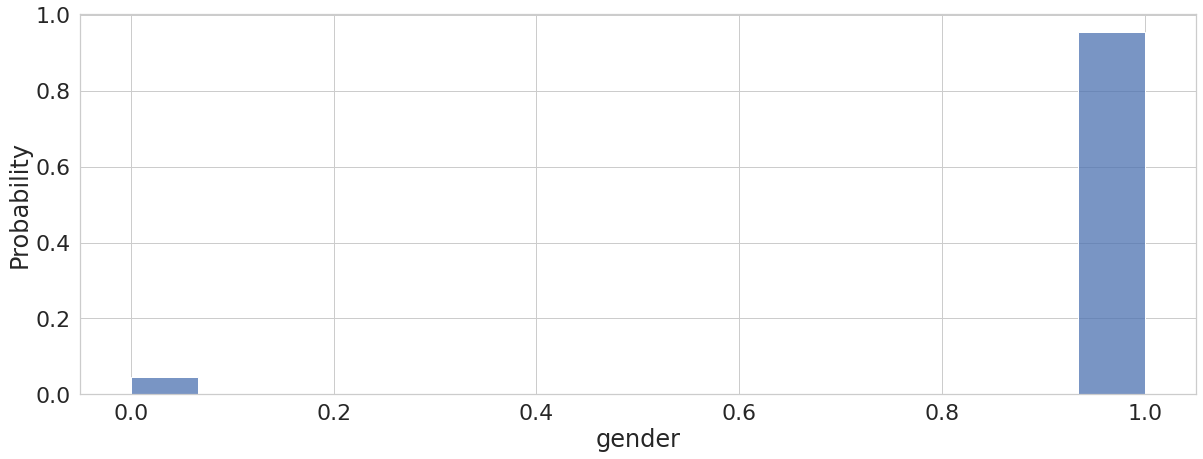

In [86]:
sns.set(
    font_scale=2,
    style     ="whitegrid",
    rc        ={'figure.figsize':(20,7)}
)
sns.histplot(data=users_and_types, x="gender", stat='probability')
plt.show()

`Изучение возрастных характеристик:

In [87]:
users_and_types.groupby(['groups', 'age'], as_index=False).size()

,groups,age,size
0,control_1,16,82
1,control_1,17,22
2,control_1,18,74
3,control_1,19,93
4,control_1,20,116
...,...,...,...
166,test,76,1
167,test,77,1
168,test,83,1
169,test,98,1


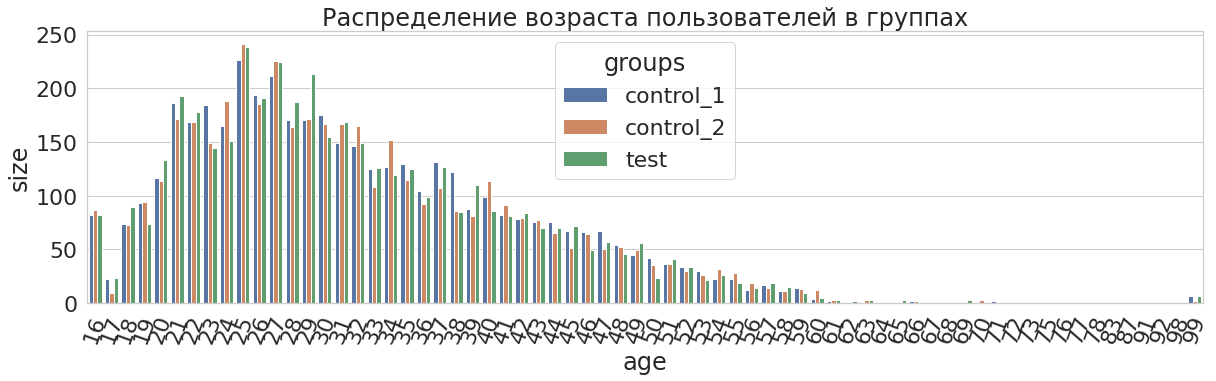

In [88]:
# отобразим на графике распределение по возрасту в группах 
plt.figure(figsize = (20,5))
sns.barplot(data = users_and_types.groupby(['groups', 'age'], as_index=False).size(), 
            x="age", y="size", hue='groups').set_title("Распределение возраста пользователей в группах")
plt.xticks(rotation=70)
plt.show()

`показатели по возрасту среди групп схожи, хотя также можем заметить, что есть люди 90+ лет, что может говорить либо о некорректности данных, вводимых пользователем.

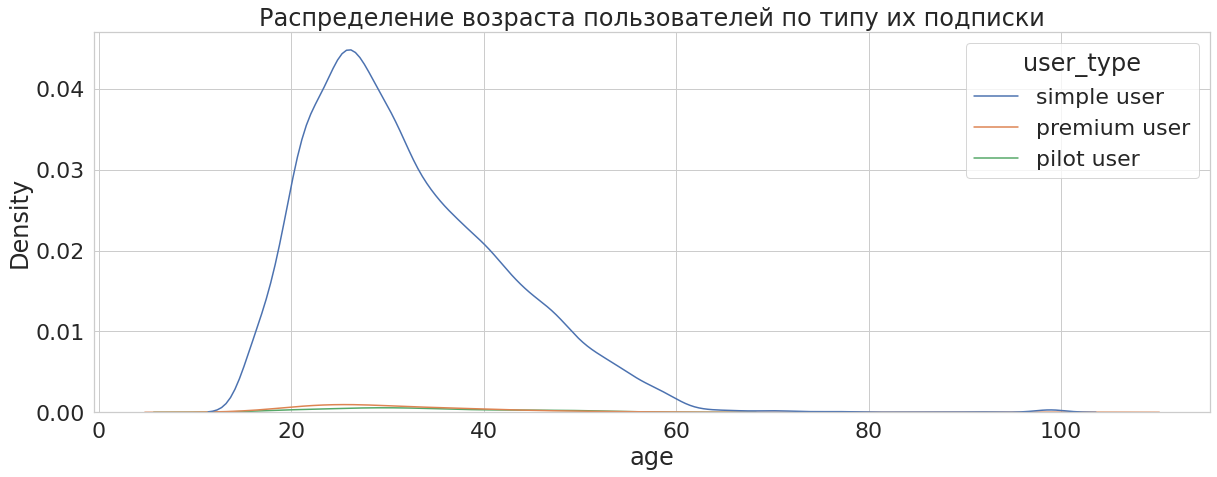

In [89]:
# отобразим на графике распределение по возрасту по типу их подписки
sns.set(
    font_scale=2,
    style     ="whitegrid",
    rc        ={'figure.figsize':(20,7)}
)
sns.kdeplot(data=users_and_types, x="age", hue='user_type')\
    .set_title("Распределение возраста пользователей по типу их подписки")
plt.show()

In [90]:
# отобразим на графике распределение по возрасту и по гендеру

age_users = users_and_types.groupby(['age','gender','user_type'], as_index=False) \
                         .agg({'uid':'count'}) \
                         .sort_values('age', ascending=True)
age_users

,age,gender,user_type,uid
0,16,0,simple user,23
1,16,1,pilot user,1
2,16,1,premium user,2
3,16,1,simple user,225
4,17,0,simple user,7
...,...,...,...,...
195,92,1,simple user,1
196,98,1,simple user,2
197,99,0,simple user,1
198,99,1,premium user,3


Text(0.5, 1.0, 'Распределение пользователей по возрасту и по гендеру')

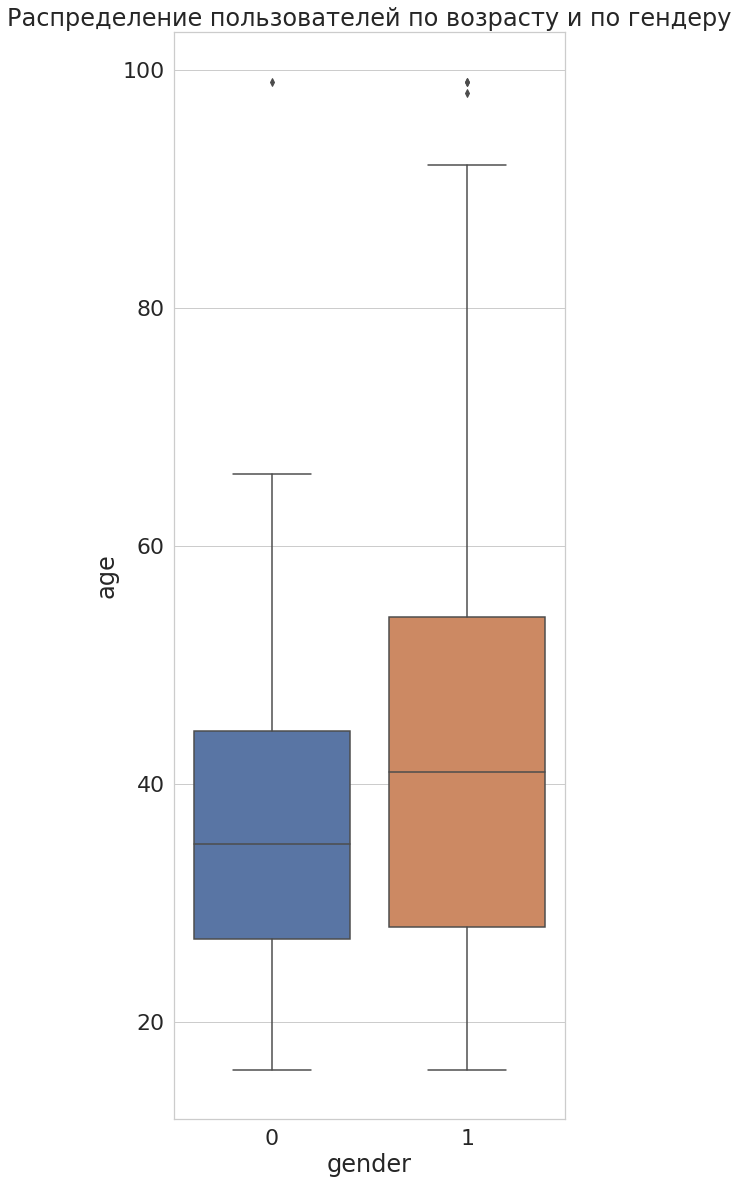

In [91]:
sns.set(
    font_scale=2,
    style     ="whitegrid",
    rc        ={'figure.figsize':(7,20)}
)
sns.boxplot(data=age_users, x="gender", y="age").set_title("Распределение пользователей по возрасту и по гендеру")

`Возраст гендера 1 в среднем выше, чем у 0 на платформе. Имеются в данных выбросы. Скорее всего, выбросы - это пользователи произвольно указывают свой возраст

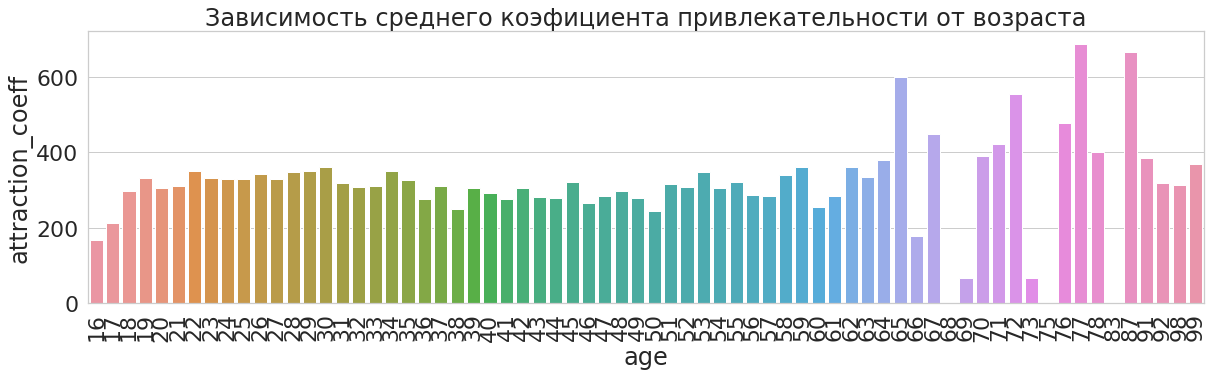

In [92]:
# отобразим на графике распределение юзеров по возрасту в зависимости от коэффициента привлекательности.
sns.set(
    font_scale=2,
    style     ="whitegrid",
    rc        ={'figure.figsize':(20,5)}
)
coef = users_and_types.groupby(['age'], as_index=False).agg({'attraction_coeff': 'mean'})
sns.barplot(data=coef, x="age", y='attraction_coeff')\
    .set_title("Зависимость среднего коэфициента привлекательности от возраста")
plt.xticks(rotation = 90)  
plt.show()

`Можно сделать вывод, что нет зависимости параметра привлекательности от возраста пользователей. Соотношение среднего числа лайков на число просмотров не изменяется

Text(0.5, 1.08, 'Распределение пользователей в зависимости от нижней границы поиска по возрасту')

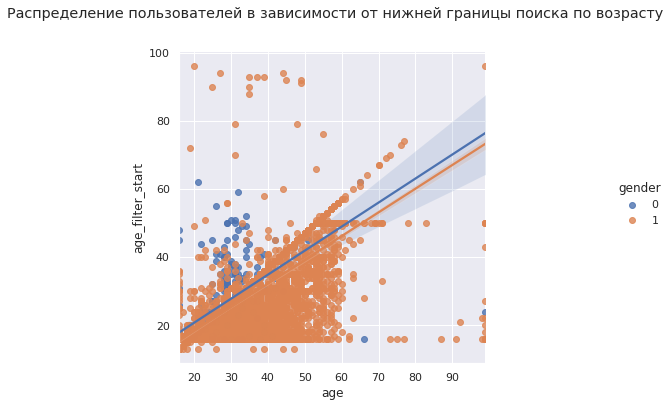

In [93]:
# отобразим на графике распределение юзеров в зависимости от нижней границы поиска по возрасту.
sns.set(rc={'figure.figsize': (20, 15)})
graph = sns.lmplot(x="age", y="age_filter_start", hue="gender", data=users_and_types)
graph.fig.suptitle("Распределение пользователей в зависимости от нижней границы поиска по возрасту", y=1.08)

Text(0.5, 1.08, 'Распределение пользователей в зависимости от верхней границы поиска по возрасту')

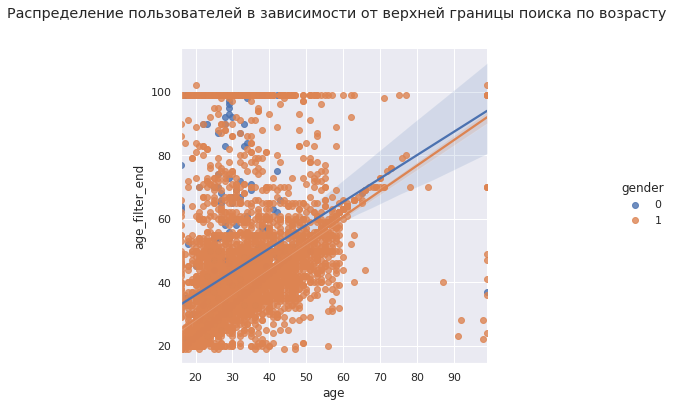

In [94]:
# отобразим на графике распределение в зависимости от верхней границы поиска по возрасту.
sns.set(rc={'figure.figsize': (20, 15)})
graph = sns.lmplot(x="age", y="age_filter_end", hue="gender", data=users_and_types)
graph.fig.suptitle("Распределение пользователей в зависимости от верхней границы поиска по возрасту", y=1.08)

Text(0.5, 1.0, 'Корреляция количественных данных')

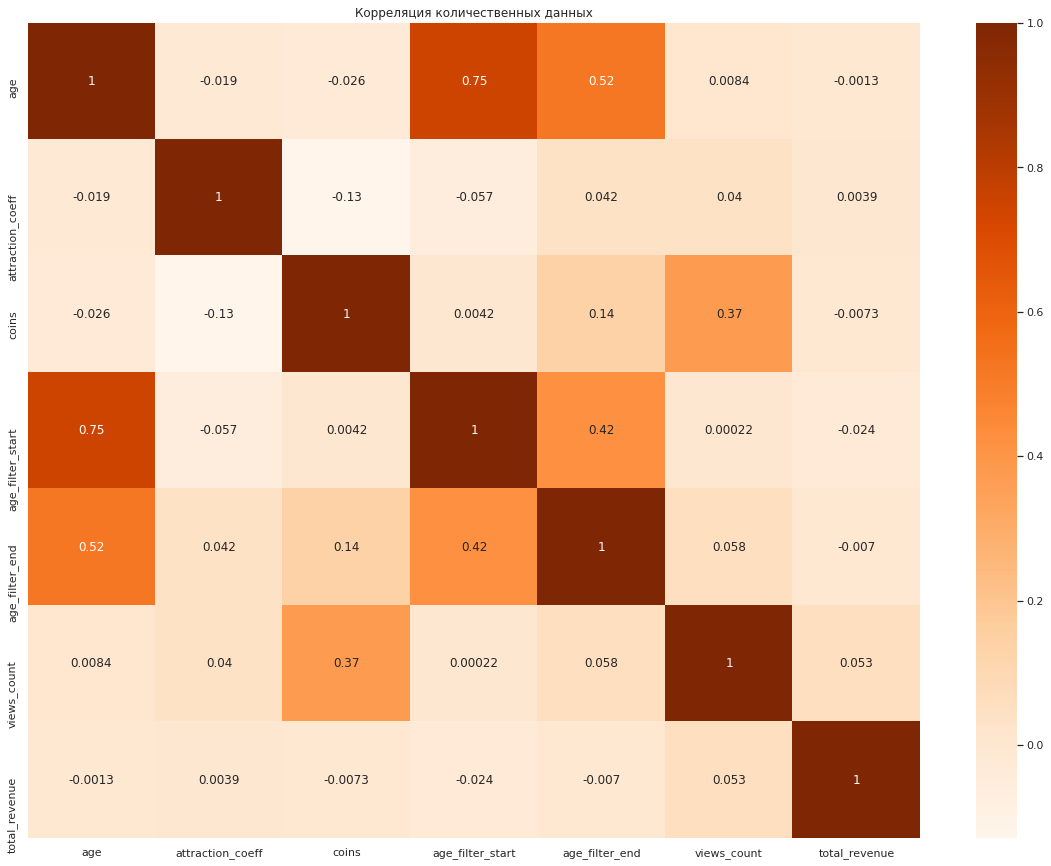

In [95]:
# Корреляция количественных данных:
sns.set(rc={'figure.figsize': (20, 15)})
sns.heatmap(users_and_types[['age', 'attraction_coeff', 'coins', 'age_filter_start',
    'age_filter_end', 'views_count', 'total_revenue']]\
    .corr(), annot=True, cmap='Oranges').set_title("Корреляция количественных данных")

`Значимая корреляция имеется только с данными возрастных фильтров и возраста самого пользователя.

`Возраст нижней границы поиска прямо пропорционален возрасту юзера (0.75). При этом зависимость верхней границы менее коррелирует со значением возраста пользователя (0.52). Предполагаю, часть пользователей (чаще женщины) ищет партнера постарше.

`Изучим коэффициент привлекательности в разрезе подписки:

In [96]:
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,0.0
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,0.0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,0.0


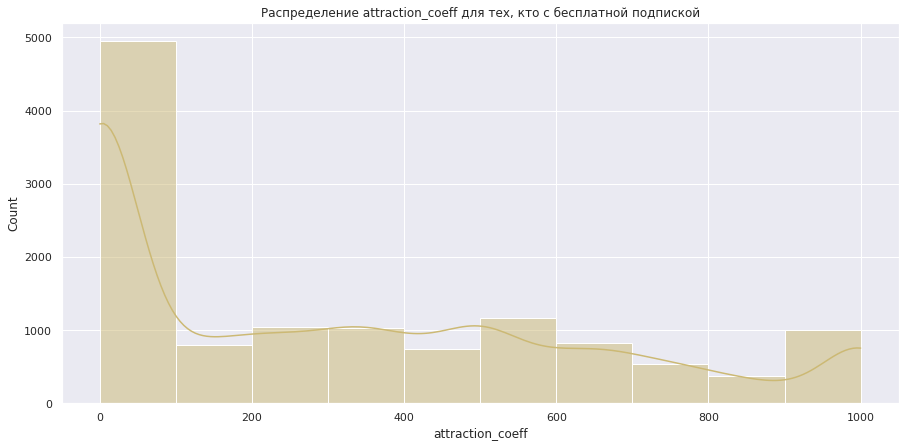

In [97]:
sns.set(rc={'figure.figsize':(15,7)})
sns.histplot(data=users_and_types.query('user_type == "simple user"'), x="attraction_coeff",
    kde=True, bins=10, color='y')\
    .set_title("Распределение attraction_coeff для тех, кто с бесплатной подпиской")
plt.show()

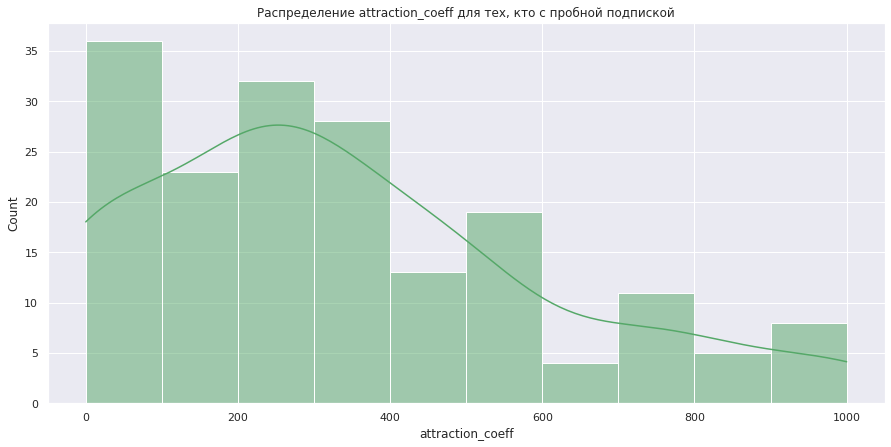

In [98]:
sns.set(rc={'figure.figsize':(15,7)})
sns.histplot(data=users_and_types.query('user_type == "pilot user"'), x="attraction_coeff", kde=True, bins=10, color='g')\
    .set_title("Распределение attraction_coeff для тех, кто с пробной подпиской")
plt.show()

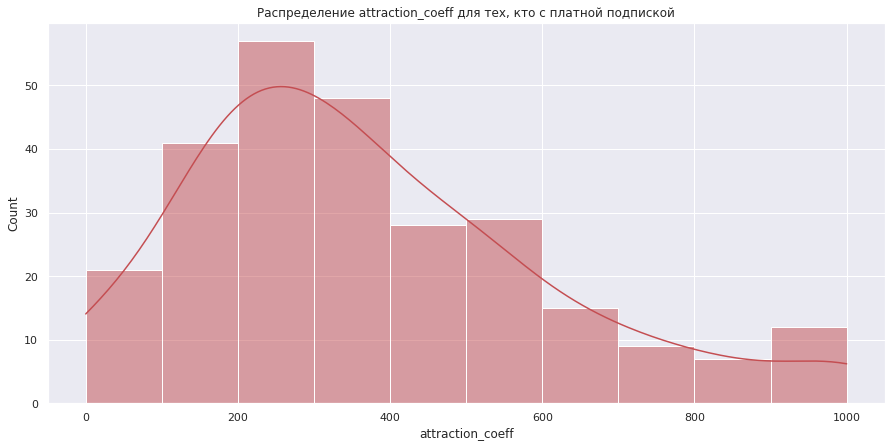

In [99]:
sns.set(rc={'figure.figsize':(15,7)})
sns.histplot(data=users_and_types.query('user_type == "premium user"'), x="attraction_coeff", kde=True, bins=10, color='r')\
    .set_title("Распределение attraction_coeff для тех, кто c платной подпиской")
plt.show()

`Можно сделать вывод о том, премиум версия действительно работает, ведь она увеличивает конверсию просмотра в лайк. На втором месте по конверсии подписка на пробном периоде. 

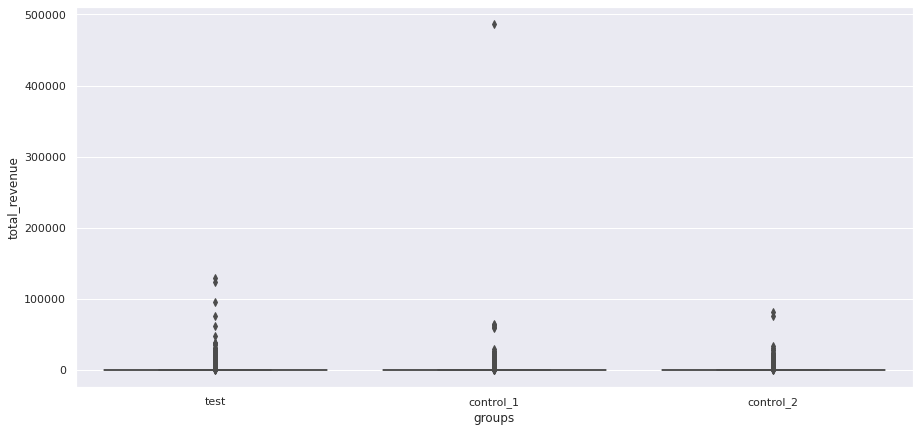

In [100]:
sns.boxplot(x = 'groups' , y = 'total_revenue', data = users_and_types)

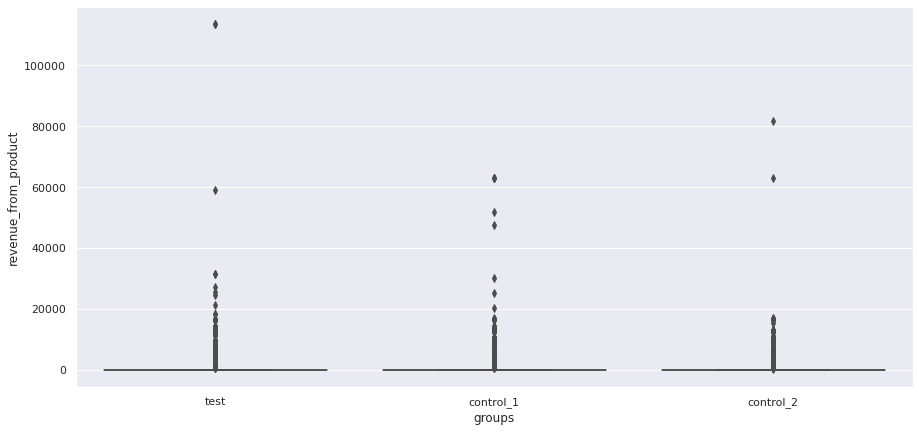

In [101]:
sns.boxplot(x = 'groups' , y = 'revenue_from_product', data = users_and_types)

In [102]:
# Посмотрим на выбросы в доходах. 3 пользователя (2 из которых из Арабских Эмиратов) 
# имеют на сайте больше всего трат. Оставлю их
users_and_types.query('revenue_from_product > 80000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
992,892038759,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565,test,premium_no_trial,premium user,20,113477.0
3629,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870,test,premium_no_trial,premium user,6,113477.0
9996,891778551,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,1.0,1.0,81796,control_2,premium_no_trial,premium user,6,81796.0


`Посмотрим на количество пользователей

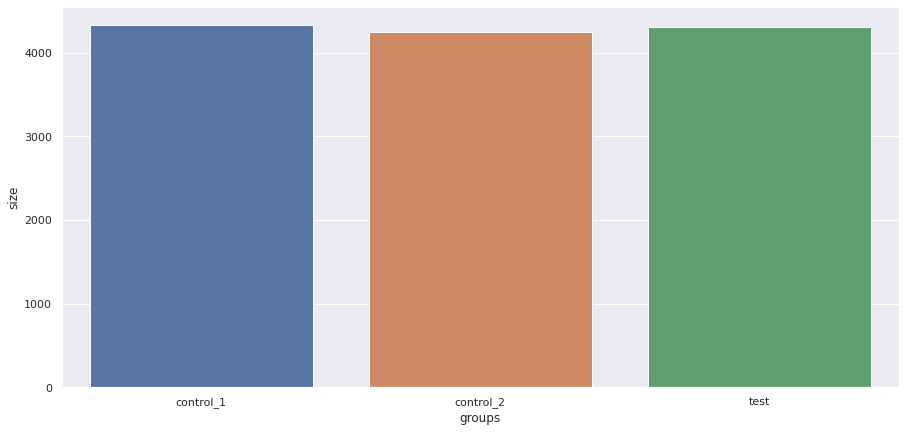

In [103]:
sns.barplot(data=users_and_types.groupby("groups", as_index=False).size(), x='groups', y='size')

In [104]:
x = users_and_types.groupby('groups', as_index=False).size()
x

,groups,size
0,control_1,4330
1,control_2,4249
2,test,4308


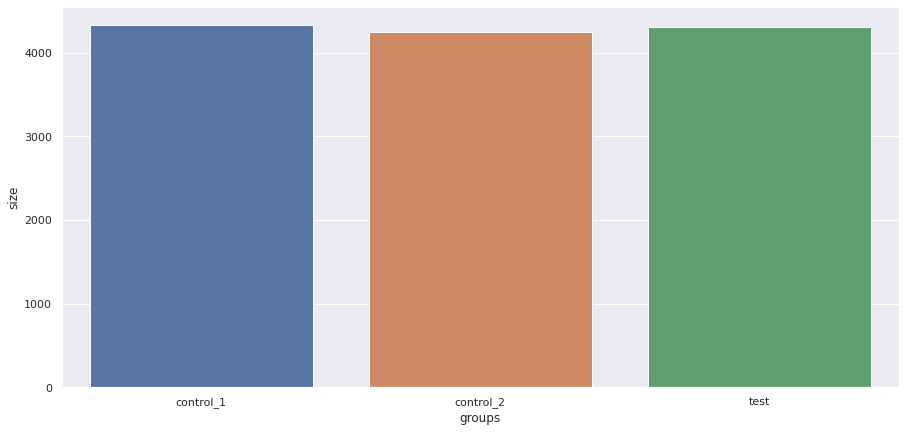

In [105]:
sns.barplot(data=x, x='groups', y='size')

`Посмотрим, равное ли распределение по гендеру:

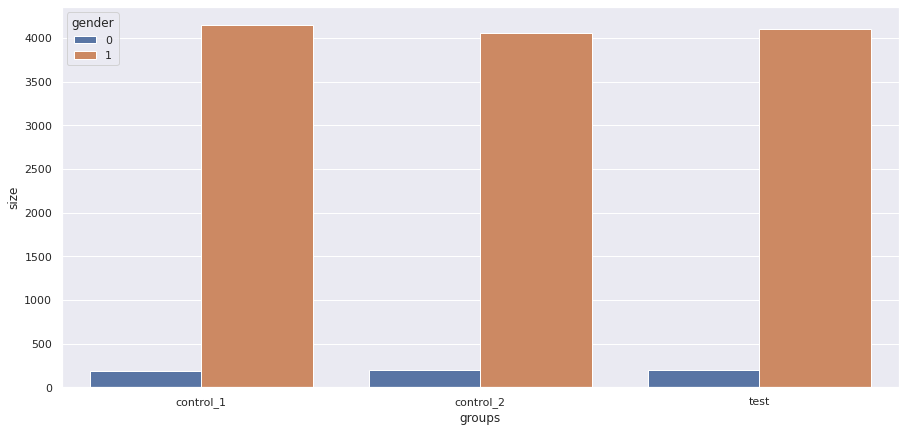

In [106]:
sns.barplot(data=users_and_types.groupby(["groups", "gender"], as_index=False).size(), x='groups', y='size', hue='gender')

`Буду проверять группы на предмет однородности таких параметров, как гендер и страна проживания, т.к. считаю их самыми важными

In [107]:
df = users_and_types.groupby(['country', 'groups'], as_index=False).agg({'uid': 'count'}).sort_values('uid', ascending = False)
df

,country,groups,uid
108,United States of America,control_2,1486
107,United States of America,control_1,1471
109,United States of America,test,1450
3,Argentina,control_2,397
4,Argentina,test,396
...,...,...,...
70,Peru,control_2,1
71,Peru,test,1
72,Philippines,control_1,1
73,Philippines,test,1


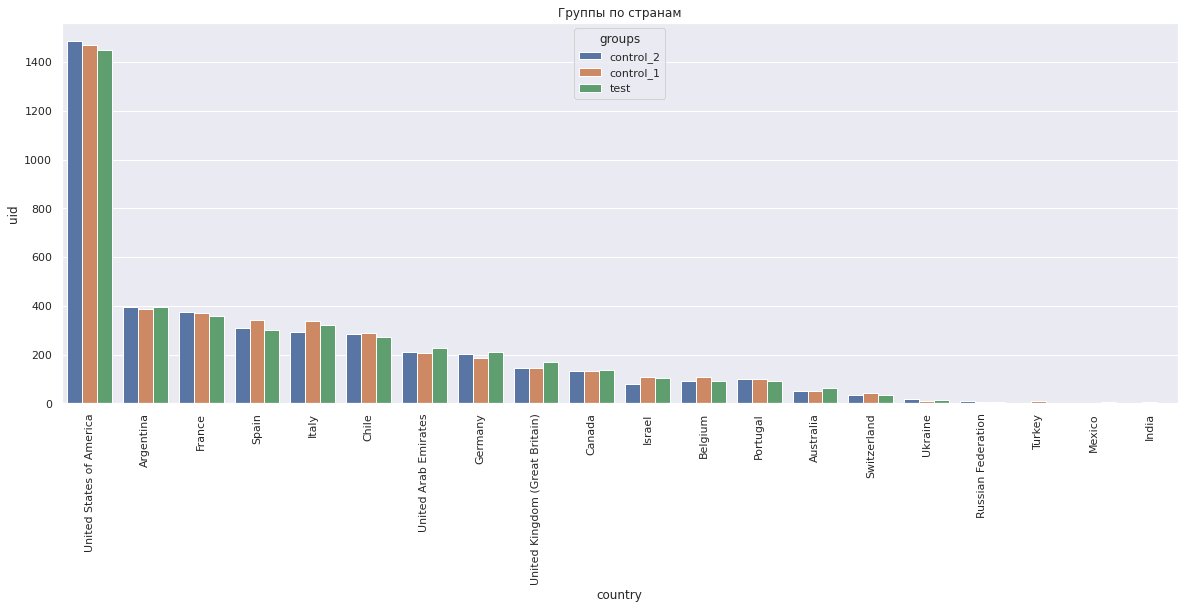

In [108]:
sns.set(rc={'figure.figsize': (20, 7)})
sns.barplot(data=df.query('uid > 5'), x="country", y='uid', hue="groups")\
    .set_title("Группы по странам")
plt.xticks(rotation=90)
plt.show()

`На диаграмме видно, что данные между группами пользователей по странам распределены равномерно. USA значительно выделяется по количеству пользователей

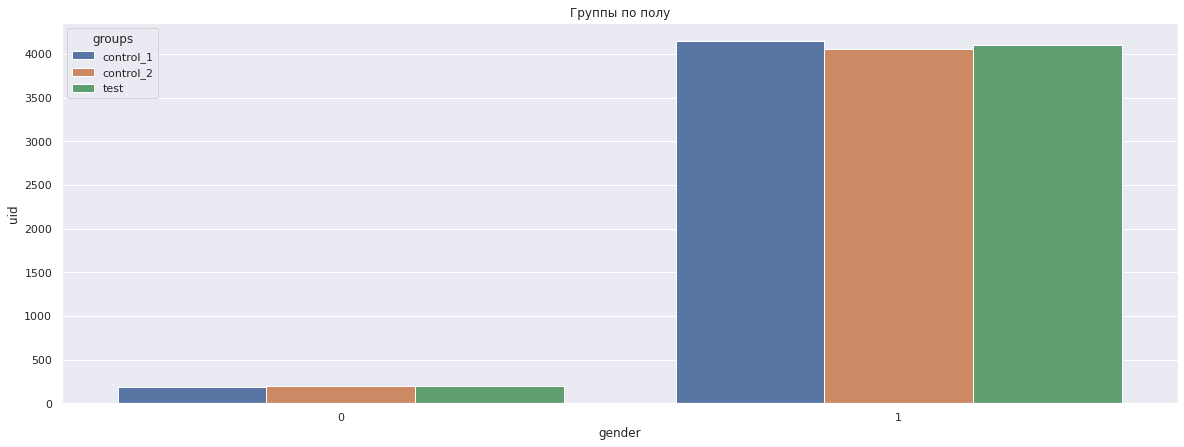

In [109]:
sns.set(rc={'figure.figsize': (20, 7)})
df = users_and_types.groupby(['gender', 'groups'], as_index=False).agg({'uid': 'count'})
sns.barplot(data=df.query('uid > 5'), x="gender", y='uid', hue="groups")\
    .set_title("Группы по полу")
plt.show()

`На диаграмме видно, что данные между группами пользователей по полу распределены равномерно. Количесво гендера "1" значительно больше, чем "0"

**Выборки репрезентативны по признакам, не связанными с основными метриками, а именно: по гендерному признаку, по странам, по возрасту, по коэфициенту привлекательности, границам поиска по возрасту**

**Промежуточный вывод.  Таким образом, можно сказать, что данные в группах распределены равномерно. A/A тестирование должно дать позитивный результат.** 

### 4) А/А тестирование. Проверка системы сплитования

`До проведения A/B тестов нужно провести А/A тестирование, которое должно подтвердить однородность групп и корректность системы сплитования.  

Проверим метрики, которые мы выбрали для интерпритации результатов А/В тестирования:

- средняя выручка всех пользователей сайта(ARPU)
- средняя выручка премиум пользователей (ARPPU)
- конверсия пользователя в премиум пользователя (CR)

In [110]:
users_and_types.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,0.0
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,0.0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,0.0


Посмотрим на количество людей с премиумом и без премиума в контрольных группах. Поскольку первой целью исследования является анализ влияния изменения подписки именно на Премиум группу, то надo учитывать, что обладатели пробного аккаунта те же пользователи, не купившие Премиум, как и simple user. Так что учтем этот факт и сделаем новый разрез пользователей

In [111]:
users_and_types['user_type_AB'] = users_and_types['user_type']\
    .apply(lambda x: 'simple+pilot' if x != 'premium user' else 'premium')

In [112]:
users_and_types.user_type_AB.value_counts()

simple+pilot    12620
premium           267
Name: user_type_AB, dtype: int64

Провожу сравнение двух контрольных групп:

In [113]:
# отсортируем данные, оставим только контрольные группы

control = users_and_types.query('groups != "test"')

# посмотрим на количество пользователей в каждой группе
control.groupby('groups').agg({'uid' : 'count'})
# количество пользователей в контрольных группах примерно одинаково

,uid
groups,
control_1,4330
control_2,4249


#### A/A: ARPU

In [114]:
# сравним среднюю выручку от подписки Премиум в контрольных группах (ARPU)
ARPU_control_1 =round((control.query("groups == 'control_1' and user_type_AB == 'premium'").revenue_from_product.sum()\
               /control.query("groups == 'control_1'").uid.nunique()),2)
ARPU_control_1
# в 1 контрольной группе средняя выручка немного выше

179.97

In [115]:
ARPU_control_2 =round((control.query("groups == 'control_2' and user_type_AB == 'premium'").revenue_from_product.sum()\
               /control.query("groups == 'control_2'").uid.nunique()),2)
ARPU_control_2

174.34

In [116]:
data = {
    'groups': ['control_1', 'control_2'],
    'ARPU': [ARPU_control_1, ARPU_control_2],
}
ARPU_tab = pd.DataFrame(data)
ARPU_tab

,groups,ARPU
0,control_1,179.97
1,control_2,174.34


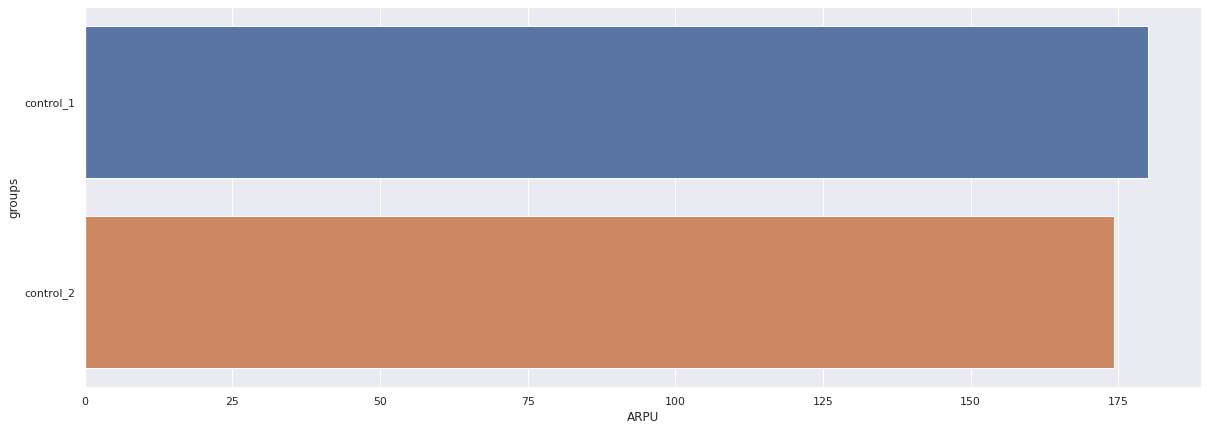

In [117]:
sns.barplot(data=ARPU_tab,  x='ARPU', y='groups')

Сравним среднюю выручку от всех продуктов по всем пользователям в контрольных группах (ARPU_all)

In [118]:
ARPU_all_control_1 =round((control.query("groups == 'control_1'").revenue_from_product.sum()\
               /control.query("groups == 'control_1'").uid.nunique()),2)
ARPU_all_control_1
# в 1 контрольной группе средняя выручка немного выше

407.04

In [119]:
ARPU_all_control_2 =round((control.query("groups == 'control_2'").revenue_from_product.sum()\
               /control.query("groups == 'control_2'").uid.nunique()),2)
ARPU_all_control_2

355.82

In [120]:
data = {
    'groups': ['control_1', 'control_2'],
    'ARPU_all': [ARPU_all_control_1, ARPU_all_control_2],
}
ARPU_all_tab = pd.DataFrame(data)
ARPU_all_tab

,groups,ARPU_all
0,control_1,407.04
1,control_2,355.82


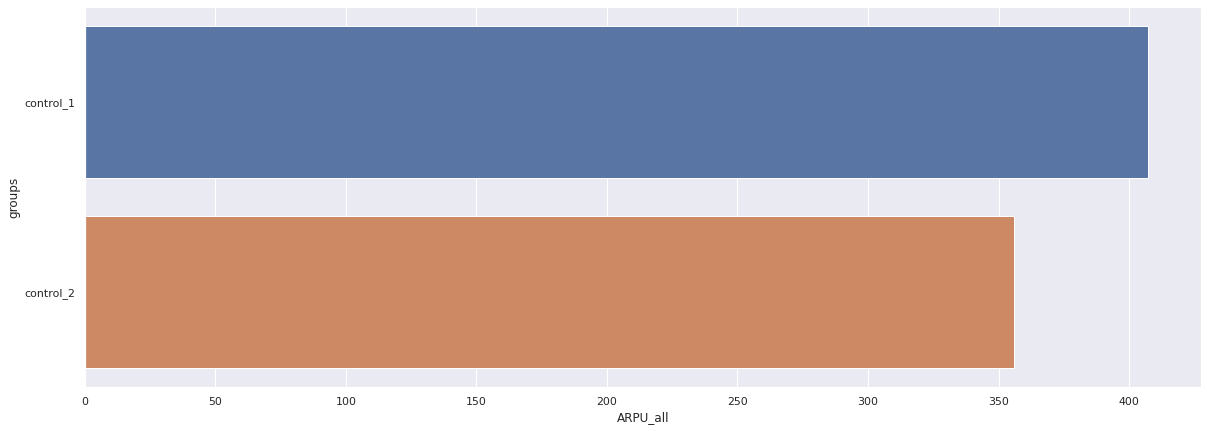

In [121]:
sns.barplot(data=ARPU_all_tab,  x='ARPU_all', y='groups')

Проверю данные на различие в дисперсиях

- H0 - статистически значимого различия в дисперсиях нет
- Н1 - статистически значимое различие в дисперсиях есть

In [122]:
pg.homoscedasticity(data = control, dv = 'revenue_from_product', group= 'groups')

,W,pval,equal_var
levene,0.886874,0.346352,True


pval > 0.05, equal_var = True 
принимаем H0 - статистически значимого различия в дисперсиях нет

Сравню средние значения выручки всех пользователей используя ttest

In [123]:
scipy.stats.ttest_ind(control.query('groups == "control_1"').revenue_from_product,
                      control.query('groups == "control_2"').revenue_from_product)

Ttest_indResult(statistic=0.9417397553720265, pvalue=0.34635241889072266)

pvalue > 0.05

Принимаем H0 - статистически значимого различия в дисперсиях нет.
Значит средняя выручка всех пользователей в контрольных группах статистически значимо не отличается

####  A/A: ARPPU

Сравниваю среднюю выручку премиум пользователей в контрольных группах (ARPPU)

In [124]:
ARPPU_control_1 =control.query("groups == 'control_1' and user_type_AB == 'premium'").revenue_from_product.sum()\
                /control.query("groups == 'control_1' and user_type_AB == 'premium'").uid.nunique()
ARPPU_control_1

7871.30303030303

In [125]:
ARPPU_control_2 =control.query("groups == 'control_2' and user_type_AB == 'premium'").revenue_from_product.sum()\
                /control.query("groups == 'control_2' and user_type_AB == 'premium'").uid.nunique()
ARPPU_control_2

7334.188118811881

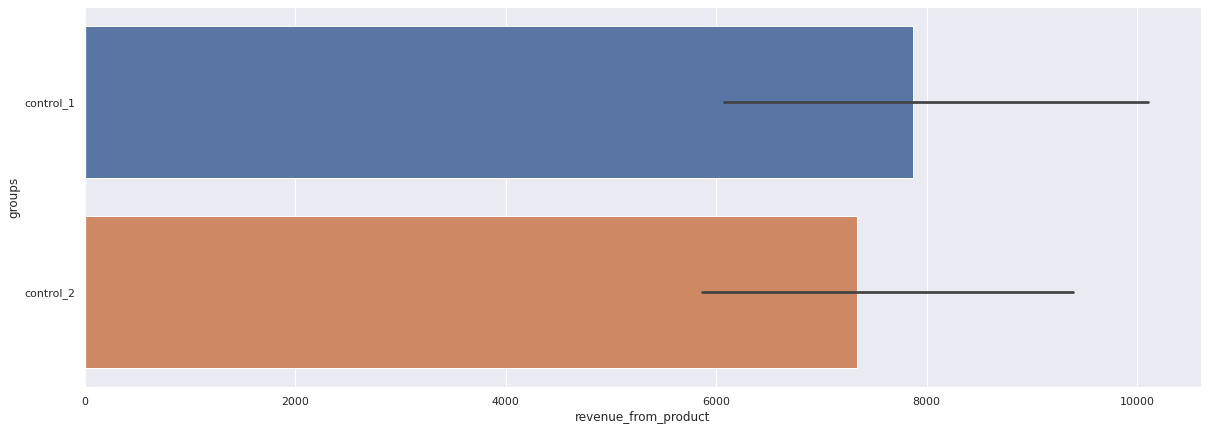

In [126]:
sns.barplot(data=control.query('user_type_AB == "premium"'),  x='revenue_from_product', y='groups')

Проверю данные на различие в дисперсиях

- H0 - статистически значимого различия в дисперсиях нет
- Н1 - статистически значимое различие в дисперсиях есть

In [127]:
pg.homoscedasticity(data = control.query('user_type_AB == "premium"'), dv = 'revenue_from_product', group= 'groups')

,W,pval,equal_var
levene,0.349826,0.554886,True


pval > 0.05, equal_var = True 

принимаем H0 - статистически значимого различия в дисперсиях нет

Сравню средние значения выручки Премиум пользователей используя ttest

In [128]:
scipy.stats.ttest_ind(control.query('groups == "control_1" and user_type_AB == "premium"').revenue_from_product, 
                      control.query('groups == "control_2" and user_type_AB == "premium"').revenue_from_product)

Ttest_indResult(statistic=0.3710159116724573, pvalue=0.7110223402654123)

pvalue > 0.05

Принимаем H0 - статистически значимого различия в дисперсиях нет. Значит средняя выручка Премиум пользователей в контрольных группах статистически значимо не отличается

####  A/A: CR

Для расчета СR пользователя в премиум пользователя посмотрим на соотношение пользователей с премиум и без премиум

In [129]:
tab = pd.crosstab(control.groups, 
            control.user_type_AB)
tab

user_type_AB,premium,simple+pilot
groups,,
control_1,99,4231
control_2,101,4148


Как видно, между контрольными группами примерно равное соотношение премиум пользователей и пользователей без премиум

Я хочу проверить статистичестически взаимосвязь между наличием премиум и распредлением по группам. 
Выбираю хи-квадрат, потому что сравниваю качественные метрики.
- Н0 взаимосвязи между переменными нет, наличие премиум подписки не зависит от распределения по группам, между группами по этому признаку различий нет
- Н1 взаимосвязь между переменными есть, наличие премиум подписки зависит от распределения по группам, между группами есть различие по этому признаку

In [130]:
chi2, p, dof, expected = chi2_contingency(tab)
p

0.836268975273655

Хи квадрат, pval > 0.05 

Принимаем Н0: взаимосвязи между переменными нет, наличие премиум подписки не зависит от распределения по группам, между группами по этому признаку различий нет

Для расчета конверсии посчитаю премиум пользователей по группам и всех пользователей сайта по группам

In [131]:
tab

user_type_AB,premium,simple+pilot
groups,,
control_1,99,4231
control_2,101,4148


In [132]:
tab['CR'] = tab['premium'] / ((tab['simple+pilot'] + tab['premium'])) *100
tab

user_type_AB,premium,simple+pilot,CR
groups,,,
control_1,99,4231,2.286374
control_2,101,4148,2.377030


Добавлю в таблицу для наглядности ARPU, ARPPU

In [133]:
tab['ARPPU'] = [ARPPU_control_1, ARPPU_control_2]
tab['ARPU'] = [ARPU_control_1, ARPU_control_2]
tab['ARPU_all'] = [ARPU_all_control_1,  ARPU_all_control_2]
tab

user_type_AB,premium,simple+pilot,CR,ARPPU,ARPU,ARPU_all
groups,,,,,,
control_1,99,4231,2.286374,7871.303030,179.97,407.04
control_2,101,4148,2.377030,7334.188119,174.34,355.82


Проверка верности расчетов с помощью формулы ARPU = ARPPU * CR

In [134]:
tab['ARPU_on_formula'] = round((tab['ARPPU'] * tab['CR']/100),2)
tab

user_type_AB,premium,simple+pilot,CR,ARPPU,ARPU,ARPU_all,ARPU_on_formula
groups,,,,,,,
control_1,99,4231,2.286374,7871.303030,179.97,407.04,179.97
control_2,101,4148,2.377030,7334.188119,174.34,355.82,174.34


In [135]:
tab['ARPU'] == tab['ARPU_on_formula']

groups
control_1    True
control_2    True
dtype: bool

Проверка пройдена успешно. Метрики рассчитаны верно

**Результаты A/A тестирования подтвердили, что система сплитования работает правильно, переходим к А/В тестированию**

### 5) А/В тестирование

Проверим метрики, которые мы выбрали для интерпритации результатов А/В тестирования:

- средняя выручка всех пользователей сайта(ARPU)
- средняя выручка премиум пользователей (ARPPU)
- конверсия пользователя в премиум пользователя (CR)

В А/В тестировании я буду сравнивать тестовую группу с одной из контрольных групп, т.к. мы выяснили в А/А тесте, что статистически значимых различий при расчете наших метрик между control_1 и control_2 группой нет.

In [136]:
# в новом df оставим только тестовую и control_1 группу

In [137]:
df = users_and_types.query('groups != "control_2"')
df.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,groups,product_type,user_type,temperary_days,revenue_from_product,user_type_AB
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,no payment,simple user,14,0.0,simple+pilot
1,892044516,27,0,NaN,Germany,,1,24,30,0,0.0,0.0,0,test,no payment,simple user,1,0.0,simple+pilot
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,no payment,simple user,20,0.0,simple+pilot


Провожу сравнение двух групп:

In [138]:
# посмотрим на количество пользователей в каждой группе
df.groupby('groups').agg({'uid' : 'count'})
# количество пользователей в группах примерно одинаково

,uid
groups,
control_1,4330
test,4308


In [139]:
# сравним среднюю выручку для всех пользователей

df.groupby('groups').agg({'revenue_from_product': 'mean'})

# в тестовой группе средняя выручка выше чем в 1 контрольной группе

,revenue_from_product
groups,
control_1,407.044111
test,415.942665


#### A/B: ARPU

Сравним ARPU от выручки Премиум.

In [140]:
ARPU_control_1 =round((df.query("groups == 'control_1' and user_type_AB == 'premium'").revenue_from_product.sum()\
               /df.query("groups == 'control_1'").uid.nunique()),2)
ARPU_control_1

179.97

In [141]:
ARPU_test =round((df.query("groups == 'test' and user_type_AB == 'premium'").revenue_from_product.sum()\
               /df.query("groups == 'test'").uid.nunique()),2)
ARPU_test

188.19

In [142]:
data = {
    'groups': ['control_1', 'test'],
    'ARPU': [ARPU_control_1, ARPU_test],
}
ARPU_tab = pd.DataFrame(data)
ARPU_tab

,groups,ARPU
0,control_1,179.97
1,test,188.19


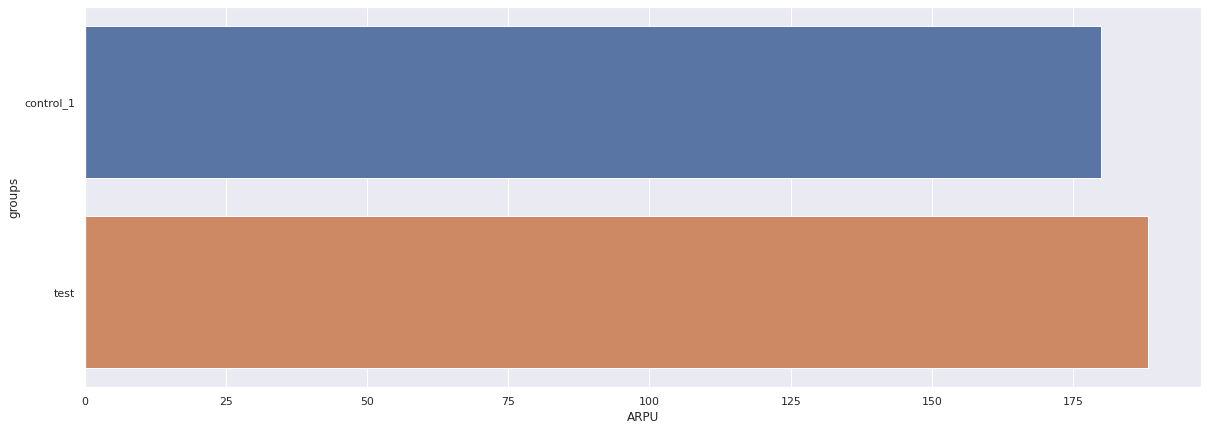

In [143]:
sns.barplot(data=ARPU_tab,  x='ARPU', y='groups')

Сравним ARPU от общей выручки.

In [144]:
# сравним ARPU
ARPU_all_control_1 =round((df.query("groups == 'control_1'").revenue_from_product.sum()\
               /df.query("groups == 'control_1'").uid.nunique()),2)
ARPU_all_control_1

407.04

In [145]:
ARPU_all_test =round((df.query("groups == 'test'").revenue_from_product.sum()\
               /df.query("groups == 'test'").uid.nunique()),2)
ARPU_all_test

415.94

In [146]:
data = {
    'groups': ['control_1', 'test'],
    'ARPU_all': [ARPU_all_control_1, ARPU_all_test],
}
ARPU_all_tab = pd.DataFrame(data)
ARPU_all_tab

,groups,ARPU_all
0,control_1,407.04
1,test,415.94


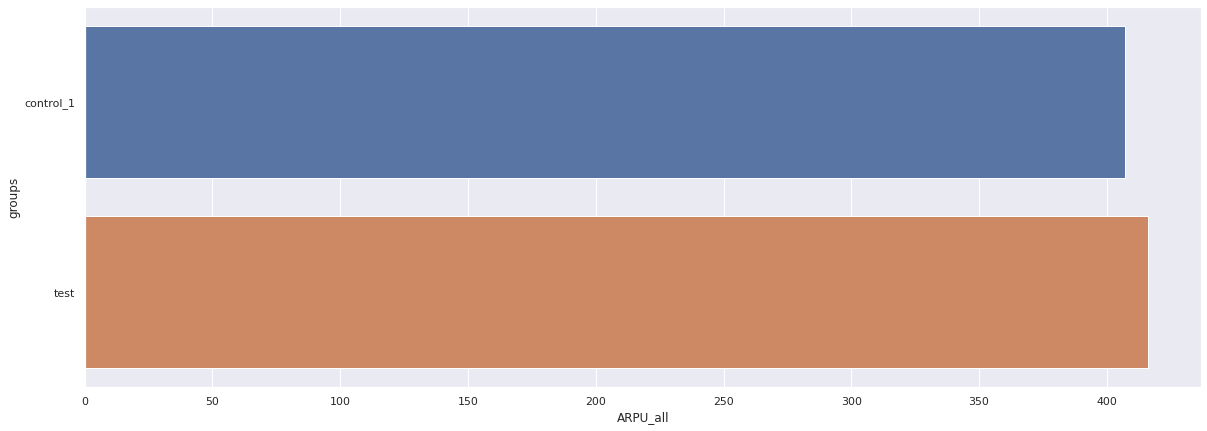

In [167]:
sns.barplot(data=ARPU_all_tab,  x='ARPU_all', y='groups')

Проверю данные на различие в дисперсиях

- H0 - статистически значимого различия в дисперсиях нет
- Н1 - статистически значимое различие в дисперсиях есть

In [148]:
pg.homoscedasticity(data = df, dv = 'revenue_from_product', group= 'groups')

,W,pval,equal_var
levene,0.018443,0.891979,True


pval > 0.05, equal_var = True 
принимаем H0 - статистически значимого различия в дисперсиях нет

Сравню средние значения выручки используя ttest

In [149]:
scipy.stats.ttest_ind(df.query('groups == "control_1"').revenue_from_product,
                      df.query('groups == "test"').revenue_from_product)

Ttest_indResult(statistic=-0.1358045973412337, pvalue=0.8919789218286513)

pvalue > 0.05

Принимаем H0 - статистически значимого различия в дисперсиях нет.
Значит средняя выручка всех пользователей в контрольной и тестовых группах статистически значимо не отличается

####  AB: ARPPU

Сравниваю ARPPU в группах

In [150]:
ARPPU_control_1 =df.query("groups == 'control_1' and user_type_AB == 'premium'").revenue_from_product.sum()\
                /df.query("groups == 'control_1' and user_type_AB == 'premium'").uid.nunique()
ARPPU_control_1

7871.30303030303

In [151]:
ARPPU_test =df.query("groups == 'test' and user_type_AB == 'premium'").revenue_from_product.sum()\
                /df.query("groups == 'test' and user_type_AB == 'premium'").uid.nunique()
ARPPU_test

12100.089552238805

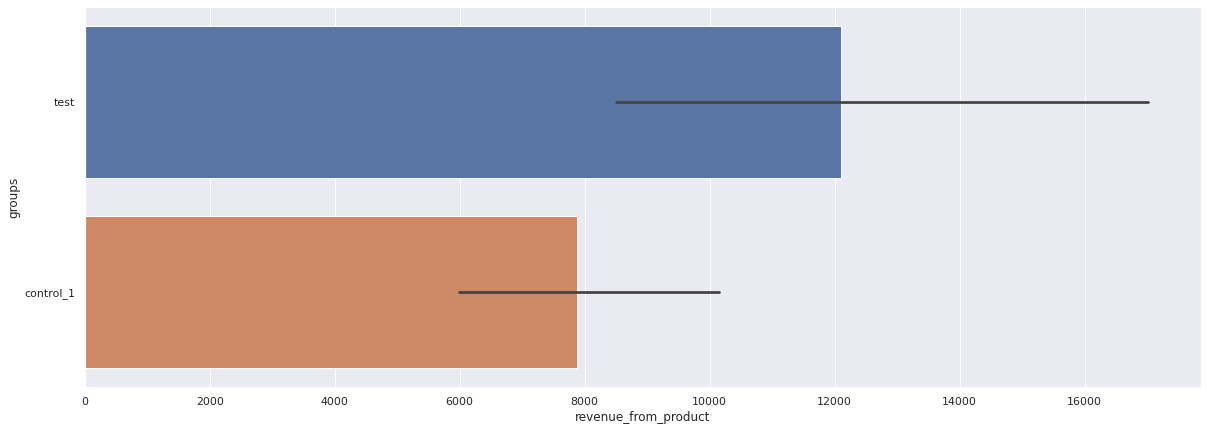

In [152]:
sns.barplot(data=df.query('user_type_AB == "premium"'),  x='revenue_from_product', y='groups')

Проверю данные на различие в дисперсиях

- H0 - статистически значимого различия в дисперсиях нет
- Н1 - статистически значимое различие в дисперсиях есть

In [153]:
pg.homoscedasticity(data = df.query('user_type_AB == "premium"'), dv = 'revenue_from_product', group= 'groups')

,W,pval,equal_var
levene,1.540065,0.21638,True


pval > 0.05, equal_var = True 

принимаем H0 - статистически значимого различия в дисперсиях нет

Сравню средние значения выручки Премиум пользователей используя ttest

In [154]:
scipy.stats.ttest_ind(df.query('groups == "control_1" and user_type_AB == "premium"').revenue_from_product, 
                      df.query('groups == "test" and user_type_AB == "premium"').revenue_from_product)

Ttest_indResult(statistic=-1.8624995351341687, pvalue=0.06432151549023761)

pvalue > 0.05

Принимаем H0 - статистически значимого различия в дисперсиях нет. Значит средняя выручка Премиум пользователей в контрольной и тестовой группах статистически значимо не отличается

#### AB: CR

Для расчета СR пользователя в премиум пользователя посмотрим на соотношение пользователей с премиум и без премиум

In [155]:
tab = pd.crosstab(df.groups, 
            df.user_type_AB)
tab

user_type_AB,premium,simple+pilot
groups,,
control_1,99,4231
test,67,4241


Как видно, между группами примерно равное соотношение пользователей без премиум и различное соотношение премиум пользователей.

Я хочу проверить статистичестически взаимосвязь между наличием премиум и распредлением по группам. 
Выбираю хи-квадрат, потому что сравниваю качественные метрики.
- Н0 взаимосвязи между переменными нет, наличие премиум подписки не зависит от распределения по группам, между группами по этому признаку различий нет
- Н1 взаимосвязь между переменными есть, наличие премиум подписки зависит от распределения по группам, между группами есть различие по этому признаку

In [156]:
chi2, p, dof, expected = chi2_contingency(tab)
p

0.016557101788717197

Хи квадрат, pval < 0.05 

Принимаем Н1 : взаимосвязь между переменными есть, наличие премиум подписки зависит от распределения по группам, между группами есть различие по этому признаку

Расчет конверсии

In [157]:
tab

user_type_AB,premium,simple+pilot
groups,,
control_1,99,4231
test,67,4241


In [158]:
tab['CR'] = tab['premium'] / ((tab['simple+pilot'] + tab['premium'])) *100
tab

user_type_AB,premium,simple+pilot,CR
groups,,,
control_1,99,4231,2.286374
test,67,4241,1.555246


Добавлю в таблицу для наглядности ARPU, ARPPU

In [159]:
tab['ARPPU'] = [ARPPU_control_1, ARPPU_test]
tab['ARPU'] = [ARPU_control_1, ARPU_test]
tab['ARPU_all'] = [ARPU_all_control_1,  ARPU_all_test]
tab

user_type_AB,premium,simple+pilot,CR,ARPPU,ARPU,ARPU_all
groups,,,,,,
control_1,99,4231,2.286374,7871.303030,179.97,407.04
test,67,4241,1.555246,12100.089552,188.19,415.94


Проверка верности расчетов с помощью формулы ARPU = ARPPU * CR

In [160]:
tab['ARPU_on_formula'] = round((tab['ARPPU'] * tab['CR']/100),2)
tab

user_type_AB,premium,simple+pilot,CR,ARPPU,ARPU,ARPU_all,ARPU_on_formula
groups,,,,,,,
control_1,99,4231,2.286374,7871.303030,179.97,407.04,179.97
test,67,4241,1.555246,12100.089552,188.19,415.94,188.19


In [161]:
tab['ARPU'] == tab['ARPU_on_formula']

groups
control_1    True
test         True
dtype: bool

Проверка пройдена успешно. Метрики рассчитаны верно

### 6) Вывод: был ли эксперимент успешен.

В ходе исследования было проведено А/A тестирование, которое подтвердило адекватность системы сплитования данных. Мы убедились в том, сравнение групп не дало статистически значимых различий, значит пользователи действительно распределились по группам случайно.

В результате проведения A/B тестирования стало ясно следующее. 

После изменения стоимости премиум-подписки для новых пользователей из нескольких стран:
- Средняя выручка с пользователей платформы онлайн-знакомств статистически значимо НЕ изменилась.
- Средняя выручка с платящих пользователей статически значимо НЕ изменилась.
- Наблюдаемое повышение показателей средней выручки в тестовой группе (ARPU , ARPPU) произошло скорее всего из-за повышения цены Премиум подписки.
- Доля пользователей платформы онлайн-знакомств, приобретающих платную Премиум подписку статистически значимо снизилась. Пользователи НЕ хотят приобретать премиум подписку по новой цене.

В целом по исследованию мы видим снижение конверсии, при средней неизменной прибыли. 
**ВЫВОД: эксперимент НЕ успешен, при изменении стоимости премиум подписки конверсия падает, пользователи НЕ хотят приобретать премиум подписку по новой цене.**